In [1]:
import argparse
import os
import numpy as np
import math
import itertools
import datetime
import time
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import torch
import glob
import random
from torch.utils.data import Dataset
from PIL import Image
import sys
import torch
from torchvision.utils import save_image, make_grid
from torch.utils.tensorboard import SummaryWriter
import warnings
from torch.nn.utils import clip_grad
import cv2
import requests
from skimage import io
from skimage.color import rgb2lab, deltaE_cie76
from typing import Union, Optional, List, Tuple, Text, BinaryIO
import pathlib

In [2]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

In [3]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, "%sA" % mode) + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(root, "%sB" % mode) + "/*.*"))

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        # Convert grayscale images to rgb
        if image_A.mode != "RGB":
            image_A = to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [4]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


##############################
#           RESNET
##############################


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


##############################
#        Discriminator
##############################


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

In [5]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))


class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

In [6]:
# Initialize generator and discriminator
input_shape = (3,256,256)
G_AB = GeneratorResNet(input_shape, 9)
G_AB.eval()

GeneratorResNet(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        

In [7]:
#For simgle Image
pil_img = Image.open('/Users/arpit/Desktop/GAN/monet2photo/temp.png')
print(pil_img.size)  
p = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
pil_to_tensor = (p(pil_img)).unsqueeze_(0)
print(pil_to_tensor.shape) 
sing_result = G_AB(pil_to_tensor)
save_image(sing_result, "/Users/arpit/Desktop/GAN/unique.png", normalize=True)

(256, 256)
torch.Size([1, 3, 256, 256])


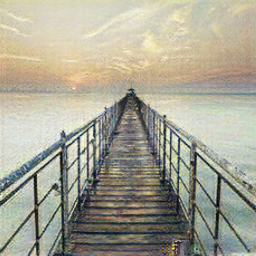

In [37]:
#original Image
pil_img

In [8]:
sing_result_2 = sing_result[0]

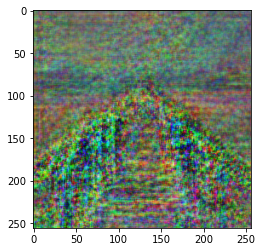

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    plt.imshow(inp)
    return inp
inp = imshow(sing_result_2.detach())

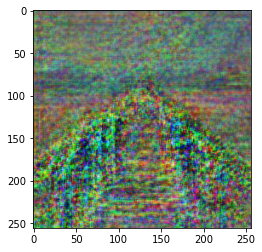

In [10]:
image = cv2.imread('/Users/arpit/Desktop/GAN/unique.png')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [11]:
#Reading Paintings
path = '/Users/arpit/Desktop/GAN/Paintings100/*.jpg'
filenames = [img for img in glob.glob(path)]
filenames.sort()
#Reading Generated Paintings
path_1 = '/Users/arpit/Desktop/GAN/GeneratedPaintiings100/*.png'
filenames_1 = [img for img in glob.glob(path_1)]
filenames_1.sort()
# Monet Palette
mp_palette = []
for name in filenames:
    img = cv2.imread(name,cv2.IMREAD_UNCHANGED)
    data = img.reshape((-1, 3))
    data = np.float32(data)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness,labels,centers = cv2.kmeans(data,1,None,criteria,10,flags)

    #print('Monet Palette Dominant color is: BGR ({})'.format(centers[0].astype(np.int32)))
    mp_palette.append(centers[0].astype(np.int32))
    
#Generated Monet Palette
gen_palette = []
for name in filenames_1:
    img = cv2.imread(name,cv2.IMREAD_UNCHANGED)
    data = img.reshape((-1, 3))
    data = np.float32(data)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness,labels,centers = cv2.kmeans(data,1,None,criteria,10,flags)

    #print('Generated Monet Palette Dominant color is: BGR({})'.format(centers[0].astype(np.int32)))
    gen_palette.append(centers[0].astype(np.int32))

In [12]:
#BGR to RGB
rgb_pal = [i[[2,1,0]] for i in mp_palette]

In [13]:
len(gen_palette)

100

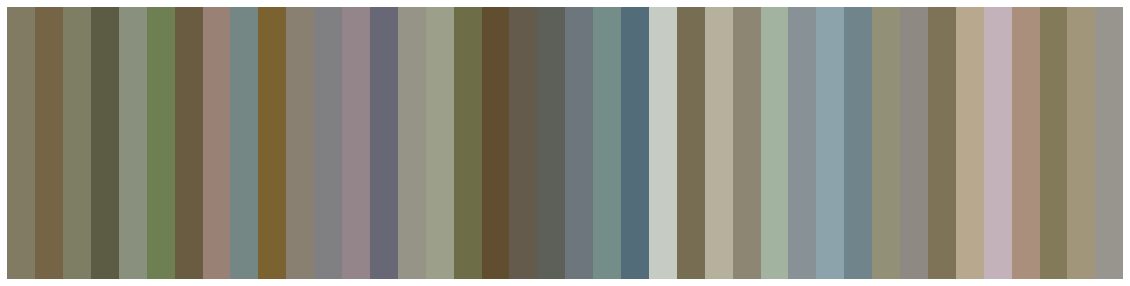

In [14]:
#Palette
scaled_colours = [[color / 255 for color in row] for row in rgb_pal]
fig, ax = plt.subplots(figsize=(20, 5))
title = "Palette"
#creating bar image
cols = len(scaled_colours)
rows = max([1,int(cols/2.5)])

# Create color Array
barFullData = np.tile(scaled_colours, (rows,1)).reshape(rows, cols, 3)
# Create Image from Array
barImg = Image.fromarray(barFullData, 'RGB')


ax.axis(xmin=0, xmax=len(barFullData))
ax.axis('off')
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
for index, colour in enumerate(scaled_colours):
    ax.axvspan(index, index + 1, color=colour)
    ax.patch.set_visible(False)

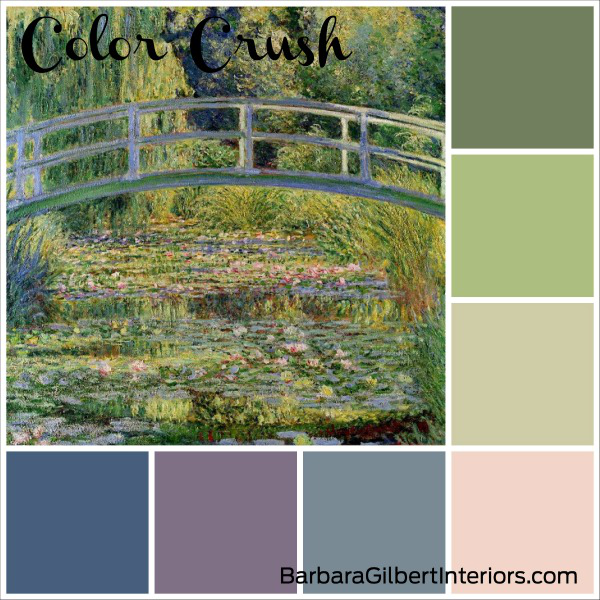

In [15]:
Image.open('/Users/arpit/Desktop/Desk.png')

In [16]:
X = [i/255 for i in rgb_pal]

In [17]:
X[0:5]

[array([0.50588235, 0.48235294, 0.38823529]),
 array([0.45882353, 0.39215686, 0.2745098 ]),
 array([0.49411765, 0.49411765, 0.39215686]),
 array([0.36078431, 0.35686275, 0.2627451 ]),
 array([0.5372549 , 0.56862745, 0.49411765])]

## Checking for the first pixel

In [18]:
#Checking if rgb is correct or not
lab_mp = rgb2lab(X)

lab_image = rgb2lab(inp[0][0])

dE = deltaE_cie76(lab_mp, lab_image)

dE

array([17.30815597, 20.53803607, 17.25360797, 13.31945044, 19.75196949,
       24.46063644, 18.37026787, 22.34573843, 14.16217905, 32.2535896 ,
       17.0993094 , 15.15814606, 20.94369563, 14.27739179, 21.76946019,
       26.02317902, 20.80363139, 22.59145144, 11.91842039,  5.16930056,
       11.99752854, 16.08240381, 12.72290658, 40.46906279, 17.35767626,
       33.02784614, 18.890985  , 31.45002212, 19.82372247, 26.23421305,
       15.03319281, 22.50881853, 18.68454563, 18.81220446, 32.93953958,
       36.51033949, 28.14201879, 21.37565349, 26.92411531, 22.16650061,
       26.38570189,  4.10904316, 30.27396566, 12.92043718, 15.83628779,
       12.43892055, 19.07559566,  6.67420251, 17.51235962, 32.88240645,
       18.59743691, 20.70155352, 26.90291745, 20.23225223, 18.09282217,
       19.72697498, 19.78452923, 18.446094  , 14.74557315, 18.41130935,
       16.35555976, 26.10299931, 31.09900178, 10.00044079,  9.5554892 ,
       28.50228016, 21.7966355 , 24.22426801, 23.37609197, 24.86

In [19]:
dE.min()

4.109043158740143

In [20]:
index_of_min = np.where(dE == dE.min())

In [21]:
index_of_min

(array([41]),)

In [38]:
X[41]

array([0.36078431, 0.38823529, 0.34901961])

In [39]:
inp[0][0]

array([0.33139636, 0.39133073, 0.36832796])

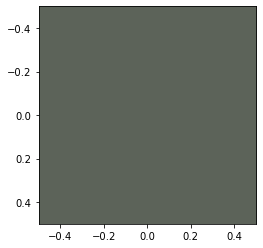

In [42]:
#first pixel of original painting
plt.imshow([[X[41]]])

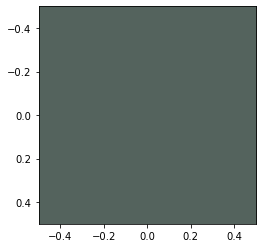

In [41]:
#pixel slelected from palette
plt.imshow([[inp[0][0]]])

## For full image

In [43]:
#https://www.compuphase.com/cmetric.htm
def labDis(Y):
    lab_mp = rgb2lab(X)

    lab_image = rgb2lab(Y)

    dE = deltaE_cie76(lab_mp, lab_image)

    return dE

In [44]:
new = torch.zeros([inp.shape[0],inp.shape[1], len(X)], dtype=torch.float64)
for i in range(0,inp.shape[0]):
    print("Row: ", i)
    for j in range(0,inp.shape[1]):
        temp = labDis(inp[i][j])
        for k in range(0,len(temp)):
            new[i][j][k] = temp[k]

Row:  0
Row:  1
Row:  2
Row:  3
Row:  4
Row:  5
Row:  6
Row:  7
Row:  8
Row:  9
Row:  10
Row:  11
Row:  12
Row:  13
Row:  14
Row:  15
Row:  16
Row:  17
Row:  18
Row:  19
Row:  20
Row:  21
Row:  22
Row:  23
Row:  24
Row:  25
Row:  26
Row:  27
Row:  28
Row:  29
Row:  30
Row:  31
Row:  32
Row:  33
Row:  34
Row:  35
Row:  36
Row:  37
Row:  38
Row:  39
Row:  40
Row:  41
Row:  42
Row:  43
Row:  44
Row:  45
Row:  46
Row:  47
Row:  48
Row:  49
Row:  50
Row:  51
Row:  52
Row:  53
Row:  54
Row:  55
Row:  56
Row:  57
Row:  58
Row:  59
Row:  60
Row:  61
Row:  62
Row:  63
Row:  64
Row:  65
Row:  66
Row:  67
Row:  68
Row:  69
Row:  70
Row:  71
Row:  72
Row:  73
Row:  74
Row:  75
Row:  76
Row:  77
Row:  78
Row:  79
Row:  80
Row:  81
Row:  82
Row:  83
Row:  84
Row:  85
Row:  86
Row:  87
Row:  88
Row:  89
Row:  90
Row:  91
Row:  92
Row:  93
Row:  94
Row:  95
Row:  96
Row:  97
Row:  98
Row:  99
Row:  100
Row:  101
Row:  102
Row:  103
Row:  104
Row:  105
Row:  106
Row:  107
Row:  108
Row:  109
Row:  110


In [46]:
#new image 
new.shape

torch.Size([256, 256, 100])

In [47]:
min_list = np.zeros([256,256])
for i in range(0,inp.shape[0]):
    for j in range(0,inp.shape[1]):
        min_list[i][j] = (torch.argmin(new[i][j]))

In [48]:
min_list = np.array(min_list)

In [49]:
min_list.shape

(256, 256)

In [50]:
new_rgb = np.zeros([256,256,3])
for i in range(0,256):
    for j in range(0,256):
        new_rgb[i][j] = X[int(min_list[i][j])]

In [51]:
new_rgb

array([[[0.36078431, 0.38823529, 0.34901961],
        [0.43137255, 0.49803922, 0.32156863],
        [0.49411765, 0.49411765, 0.39215686],
        ...,
        [0.42352941, 0.40392157, 0.43921569],
        [0.45490196, 0.55294118, 0.53333333],
        [0.47058824, 0.56862745, 0.50980392]],

       [[0.43137255, 0.49803922, 0.32156863],
        [0.43137255, 0.49803922, 0.32156863],
        [0.43137255, 0.49803922, 0.32156863],
        ...,
        [0.43921569, 0.43921569, 0.47058824],
        [0.43529412, 0.51764706, 0.54509804],
        [0.47058824, 0.56862745, 0.50980392]],

       [[0.42745098, 0.41176471, 0.41176471],
        [0.47058824, 0.56862745, 0.50980392],
        [0.43137255, 0.49803922, 0.32156863],
        ...,
        [0.38823529, 0.39607843, 0.46666667],
        [0.40392157, 0.4       , 0.55686275],
        [0.42745098, 0.45882353, 0.49019608]],

       ...,

       [[0.43137255, 0.49803922, 0.32156863],
        [0.43137255, 0.49803922, 0.32156863],
        [0.43137255, 0

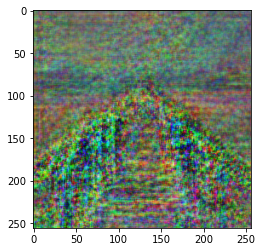

In [52]:
#Original Image
inp = imshow(sing_result_2.detach())
plt.imsave('Gan_image.png', inp)

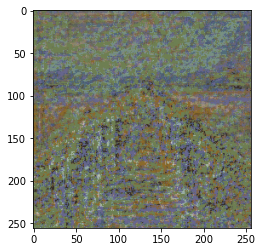

In [53]:
#Using Palette
plt.imshow(new_rgb)
plt.imsave('PaletteGan_image.png', new_rgb)